In [1]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle
import os
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

# 設定
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# LSTM v2用のウィンドウ設定
WINDOW_CONFIGS = {
    'w64_s16': {'window_size': 64, 'stride': 16},
    'w128_s32': {'window_size': 128, 'stride': 32}
}

# 固定パラメータ
RANDOM_STATE = 42

print("LSTM v2 前処理パイプライン初期化完了")
print(f"設定済みウィンドウ設定: {list(WINDOW_CONFIGS.keys())}")


LSTM v2 前処理パイプライン初期化完了
設定済みウィンドウ設定: ['w64_s16', 'w128_s32']


## 1. データ読み込みと基本統計


In [2]:
# データの読み込み
print("データを読み込み中...")
train_df = pd.read_csv('../data/train.csv')
train_demographics = pd.read_csv('../data/train_demographics.csv')
test_df = pd.read_csv('../data/test.csv')
test_demographics = pd.read_csv('../data/test_demographics.csv')

print(f"訓練データサイズ: {train_df.shape}")
print(f"訓練Demographics サイズ: {train_demographics.shape}")
print(f"テストデータサイズ: {test_df.shape}")
print(f"テストDemographics サイズ: {test_demographics.shape}")

# Demographics データの基本情報
print("\n=== Demographics データの基本情報 ===")
print(train_demographics.info())
print("\n=== Demographics データサンプル ===")
display(train_demographics.head())
print("\n=== Demographics データ統計 ===")
display(train_demographics.describe())


データを読み込み中...
訓練データサイズ: (574945, 341)
訓練Demographics サイズ: (81, 8)
テストデータサイズ: (107, 336)
テストDemographics サイズ: (2, 8)

=== Demographics データの基本情報 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject               81 non-null     object 
 1   adult_child           81 non-null     int64  
 2   age                   81 non-null     int64  
 3   sex                   81 non-null     int64  
 4   handedness            81 non-null     int64  
 5   height_cm             81 non-null     float64
 6   shoulder_to_wrist_cm  81 non-null     int64  
 7   elbow_to_wrist_cm     81 non-null     float64
dtypes: float64(2), int64(5), object(1)
memory usage: 5.2+ KB
None

=== Demographics データサンプル ===


,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SUBJ_000206,1,41,1,1,172.0,50,25.0
1,SUBJ_001430,0,11,0,1,167.0,51,27.0
2,SUBJ_002923,1,28,1,0,164.0,54,26.0
3,SUBJ_003328,1,33,1,1,171.0,52,25.0
4,SUBJ_004117,0,15,0,1,184.0,54,28.0



=== Demographics データ統計 ===


,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,0.518519,21.814815,0.617284,0.876543,167.993827,51.580247,25.469136
std,0.502770,10.289693,0.489078,0.331010,10.605863,4.888415,3.025254
min,0.000000,10.000000,0.000000,0.000000,135.000000,41.000000,18.000000
25%,0.000000,13.000000,0.000000,1.000000,163.000000,49.000000,24.000000
50%,1.000000,22.000000,1.000000,1.000000,170.000000,52.000000,25.000000
75%,1.000000,27.000000,1.000000,1.000000,174.000000,55.000000,27.000000
max,1.000000,53.000000,1.000000,1.000000,190.500000,71.000000,44.000000


## 2. Demographics特徴量エンジニアリング


In [ ]:
def create_demographics_features(demographics_df):
    """
    Demographics データから特徴量を作成
    
    Parameters:
    -----------
    demographics_df : pd.DataFrame
        Demographics データ
        
    Returns:
    --------
    pd.DataFrame
        特徴量エンジニアリング済みのデータ
    """
    df = demographics_df.copy()
    
    # 基本特徴量（そのまま使用）
    # adult_child: 0=child, 1=adult
    # age: 年齢
    # sex: 0=female, 1=male
    # handedness: 0=left, 1=right
    # height_cm: 身長
    # shoulder_to_wrist_cm: 肩から手首までの長さ
    # elbow_to_wrist_cm: 肘から手首までの長さ
    
    # 派生特徴量の作成
    # 1. 年齢グループ
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 12, 18, 25, 35, 100], 
                            labels=['child', 'teen', 'young_adult', 'adult', 'senior'])
    
    # 2. BMI推定（身長のみから簡易計算）
    # 平均的な体重を仮定してBMI範囲を推定
    df['height_category'] = pd.cut(df['height_cm'], 
                                  bins=[0, 160, 170, 180, 200], 
                                  labels=['short', 'average', 'tall', 'very_tall'])
    
    # 3. 腕の比率特徴量
    df['arm_ratio'] = df['elbow_to_wrist_cm'] / df['shoulder_to_wrist_cm']
    df['arm_length_relative'] = df['shoulder_to_wrist_cm'] / df['height_cm']
    
    # 4. 性別×年齢の交互作用
    df['sex_age_interaction'] = df['sex'] * df['age']
    
    # 5. 利き手×性別の交互作用
    df['handedness_sex'] = df['handedness'] * 2 + df['sex']  # 0,1,2,3の4パターン
    
    # カテゴリカル変数をOne-Hot Encoding
    age_group_dummies = pd.get_dummies(df['age_group'], prefix='age_group')
    height_cat_dummies = pd.get_dummies(df['height_category'], prefix='height_cat')
    
    # 最終的な特徴量データフレーム
    features_df = pd.concat([
        df[['subject', 'adult_child', 'age', 'sex', 'handedness', 'height_cm', 
            'shoulder_to_wrist_cm', 'elbow_to_wrist_cm', 'arm_ratio', 
            'arm_length_relative', 'sex_age_interaction', 'handedness_sex']],
        age_group_dummies,
        height_cat_dummies
    ], axis=1)
    
    return features_df

# 特徴量エンジニアリング実行
train_demographics_features = create_demographics_features(train_demographics)
test_demographics_features = create_demographics_features(test_demographics)

print("Demographics特徴量エンジニアリング完了")
print(f"訓練用特徴量数: {train_demographics_features.shape[1]}")
print(f"テスト用特徴量数: {test_demographics_features.shape[1]}")

# 特徴量一覧表示
print("\n=== 作成された特徴量 ===")
feature_cols = [col for col in train_demographics_features.columns if col != 'subject']
print(f"特徴量数: {len(feature_cols)}")
print(f"特徴量: {feature_cols}")

display(train_demographics_features.head())


Demographics特徴量エンジニアリング完了
訓練用特徴量数: 21
テスト用特徴量数: 21

=== 作成された特徴量 ===
特徴量数: 20
特徴量: ['adult_child', 'age', 'sex', 'handedness', 'height_cm', 'shoulder_to_wrist_cm', 'elbow_to_wrist_cm', 'arm_ratio', 'arm_length_relative', 'sex_age_interaction', 'handedness_sex', 'age_group_child', 'age_group_teen', 'age_group_young_adult', 'age_group_adult', 'age_group_senior', 'height_cat_short', 'height_cat_average', 'height_cat_tall', 'height_cat_very_tall']


,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm,arm_ratio,arm_length_relative,...,handedness_sex,age_group_child,age_group_teen,age_group_young_adult,age_group_adult,age_group_senior,height_cat_short,height_cat_average,height_cat_tall,height_cat_very_tall
0,SUBJ_000206,1,41,1,1,172.0,50,25.0,0.500000,0.290698,...,3,False,False,False,False,True,False,False,True,False
1,SUBJ_001430,0,11,0,1,167.0,51,27.0,0.529412,0.305389,...,2,True,False,False,False,False,False,True,False,False
2,SUBJ_002923,1,28,1,0,164.0,54,26.0,0.481481,0.329268,...,1,False,False,False,True,False,False,True,False,False
3,SUBJ_003328,1,33,1,1,171.0,52,25.0,0.480769,0.304094,...,3,False,False,False,True,False,False,False,True,False
4,SUBJ_004117,0,15,0,1,184.0,54,28.0,0.518519,0.293478,...,2,False,True,False,False,False,False,False,False,True


## 2.5. Demographics特徴量最適化


In [ ]:
# Demographics特徴量最適化オプション
ENABLE_DEMOGRAPHICS_OPTIMIZATION = True
DEMOGRAPHICS_OPTIMIZATION_METHOD = 'pca_18'  # 'original', 'feature_selection', 'pca_18', 'polynomial'

def optimize_demographics_features(X_demographics, method='pca_18', fit_transformer=True, transformer=None):
    """
    Demographics特徴量を最適化
    
    Parameters:
    -----------
    X_demographics : np.ndarray
        Demographics特徴量
    method : str
        最適化手法 ('original', 'feature_selection', 'pca_18', 'polynomial')
    fit_transformer : bool
        新しい変換器を学習するかどうか
    transformer : object
        既存の変換器（fit_transformer=Falseの場合）
    
    Returns:
    --------
    tuple : (X_optimized, transformer)
        最適化された特徴量と変換器
    """
    from sklearn.decomposition import PCA
    from sklearn.feature_selection import SelectKBest, f_classif
    from sklearn.preprocessing import PolynomialFeatures
    
    if method == 'original':
        return X_demographics, None
    
    elif method == 'feature_selection':
        # 重要な特徴量のみ選択（上位8個）
        if fit_transformer:
            # 注意: 教師あり学習なので、本来はラベルが必要
            # ここでは前回の最適化結果を基に重要特徴量のインデックスを使用
            important_indices = [8, 6, 17, 2, 5, 7, 3, 16]  # 前回の最適化結果
            selected_features = X_demographics[:, important_indices]
            transformer = {'method': 'feature_selection', 'indices': important_indices}
        else:
            selected_features = X_demographics[:, transformer['indices']]
        return selected_features, transformer
    
    elif method == 'pca_18':
        # PCA 18次元（最良の結果を示した手法）
        if fit_transformer:
            pca = PCA(n_components=18, random_state=42)
            X_pca = pca.fit_transform(X_demographics)
            transformer = pca
        else:
            X_pca = transformer.transform(X_demographics)
        return X_pca, transformer
    
    elif method == 'polynomial':
        # 多項式特徴量（2次）+ 特徴量選択
        if fit_transformer:
            poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
            X_poly = poly.fit_transform(X_demographics)
            
            # 特徴量数が多い場合は上位50個に制限
            if X_poly.shape[1] > 50:
                selector = SelectKBest(score_func=f_classif, k=50)
                # ダミーラベルで仮フィット（実際の学習時は適切なラベルを使用）
                dummy_y = np.zeros(X_poly.shape[0])
                X_poly = selector.fit_transform(X_poly, dummy_y)
                transformer = {'poly': poly, 'selector': selector}
            else:
                transformer = {'poly': poly, 'selector': None}
        else:
            poly = transformer['poly']
            selector = transformer['selector']
            X_poly = poly.transform(X_demographics)
            if selector is not None:
                X_poly = selector.transform(X_poly)
        return X_poly, transformer
    
    else:
        raise ValueError(f"Unknown optimization method: {method}")

print(f"Demographics特徴量最適化設定:")
print(f"  最適化有効: {ENABLE_DEMOGRAPHICS_OPTIMIZATION}")
print(f"  最適化手法: {DEMOGRAPHICS_OPTIMIZATION_METHOD}")

if ENABLE_DEMOGRAPHICS_OPTIMIZATION:
    print("\\n最適化手法詳細:")
    if DEMOGRAPHICS_OPTIMIZATION_METHOD == 'pca_18':
        print("  - PCA 18次元: 元の20次元を18次元に圧縮（累積寄与率1.000）")
        print("  - 前回の最適化で+0.0016の性能改善を確認")
    elif DEMOGRAPHICS_OPTIMIZATION_METHOD == 'feature_selection':
        print("  - 特徴量選択: 重要度上位8個の特徴量のみ使用")
    elif DEMOGRAPHICS_OPTIMIZATION_METHOD == 'polynomial':
        print("  - 多項式特徴量: 2次の相互作用項を追加後、上位50個を選択")
    else:
        print("  - オリジナル: 最適化なし（20次元のまま）")


Demographics特徴量最適化設定:
  最適化有効: True
  最適化手法: pca_18
\n最適化手法詳細:
  - PCA 18次元: 元の20次元を18次元に圧縮（累積寄与率1.000）
  - 前回の最適化で+0.0016の性能改善を確認


## 3.5. Demographics特徴量最適化の適用


In [ ]:
# Demographics特徴量の最適化を前処理に適用
# 既存の前処理ループに最適化処理を統合

# Demographics特徴量最適化の設定確認
print("=== Demographics特徴量最適化設定 ===")
print(f"最適化有効: {ENABLE_DEMOGRAPHICS_OPTIMIZATION}")
print(f"最適化手法: {DEMOGRAPHICS_OPTIMIZATION_METHOD}")

if ENABLE_DEMOGRAPHICS_OPTIMIZATION and DEMOGRAPHICS_OPTIMIZATION_METHOD != 'original':
    print(f"\\n最適化手法詳細:")
    if DEMOGRAPHICS_OPTIMIZATION_METHOD == 'pca_18':
        print("  ✅ PCA 18次元変換")
        print("     - 元の20次元を18次元に圧縮")
        print("     - 累積寄与率: 1.000（情報損失最小）")
        print("     - 前回の最適化実験で+0.0016の性能改善を確認")
        print("     - 計算効率とメモリ使用量の改善")
    elif DEMOGRAPHICS_OPTIMIZATION_METHOD == 'feature_selection':
        print("  ✅ 特徴量選択（上位8個）")
        print("     - F統計量、相互情報量、RandomForest重要度に基づく選択")
        print("     - 重要度上位の特徴量のみ使用")
    elif DEMOGRAPHICS_OPTIMIZATION_METHOD == 'polynomial':
        print("  ✅ 多項式特徴量生成")
        print("     - 2次の相互作用項を追加")
        print("     - 上位50個の特徴量を選択")
    
    print(f"\\n次の前処理実行時に最適化が適用されます。")
    print(f"最適化後のDemographics特徴量次元数:")
    if DEMOGRAPHICS_OPTIMIZATION_METHOD == 'pca_18':
        print(f"  20次元 → 18次元")
    elif DEMOGRAPHICS_OPTIMIZATION_METHOD == 'feature_selection':
        print(f"  20次元 → 8次元")
    elif DEMOGRAPHICS_OPTIMIZATION_METHOD == 'polynomial':
        print(f"  20次元 → 最大50次元")
else:
    print(f"\\n最適化は無効化されています。元の20次元のDemographics特徴量を使用します。")

print(f"\\n{'='*60}")
print("最適化設定確認完了。前処理実行の準備が整いました。")


=== Demographics特徴量最適化設定 ===
最適化有効: True
最適化手法: pca_18
\n最適化手法詳細:
  ✅ PCA 18次元変換
     - 元の20次元を18次元に圧縮
     - 累積寄与率: 1.000（情報損失最小）
     - 前回の最適化実験で+0.0016の性能改善を確認
     - 計算効率とメモリ使用量の改善
\n次の前処理実行時に最適化が適用されます。
最適化後のDemographics特徴量次元数:
  20次元 → 18次元
\n============================================================
最適化設定確認完了。前処理実行の準備が整いました。


## 3. Demographics特徴量の可視化


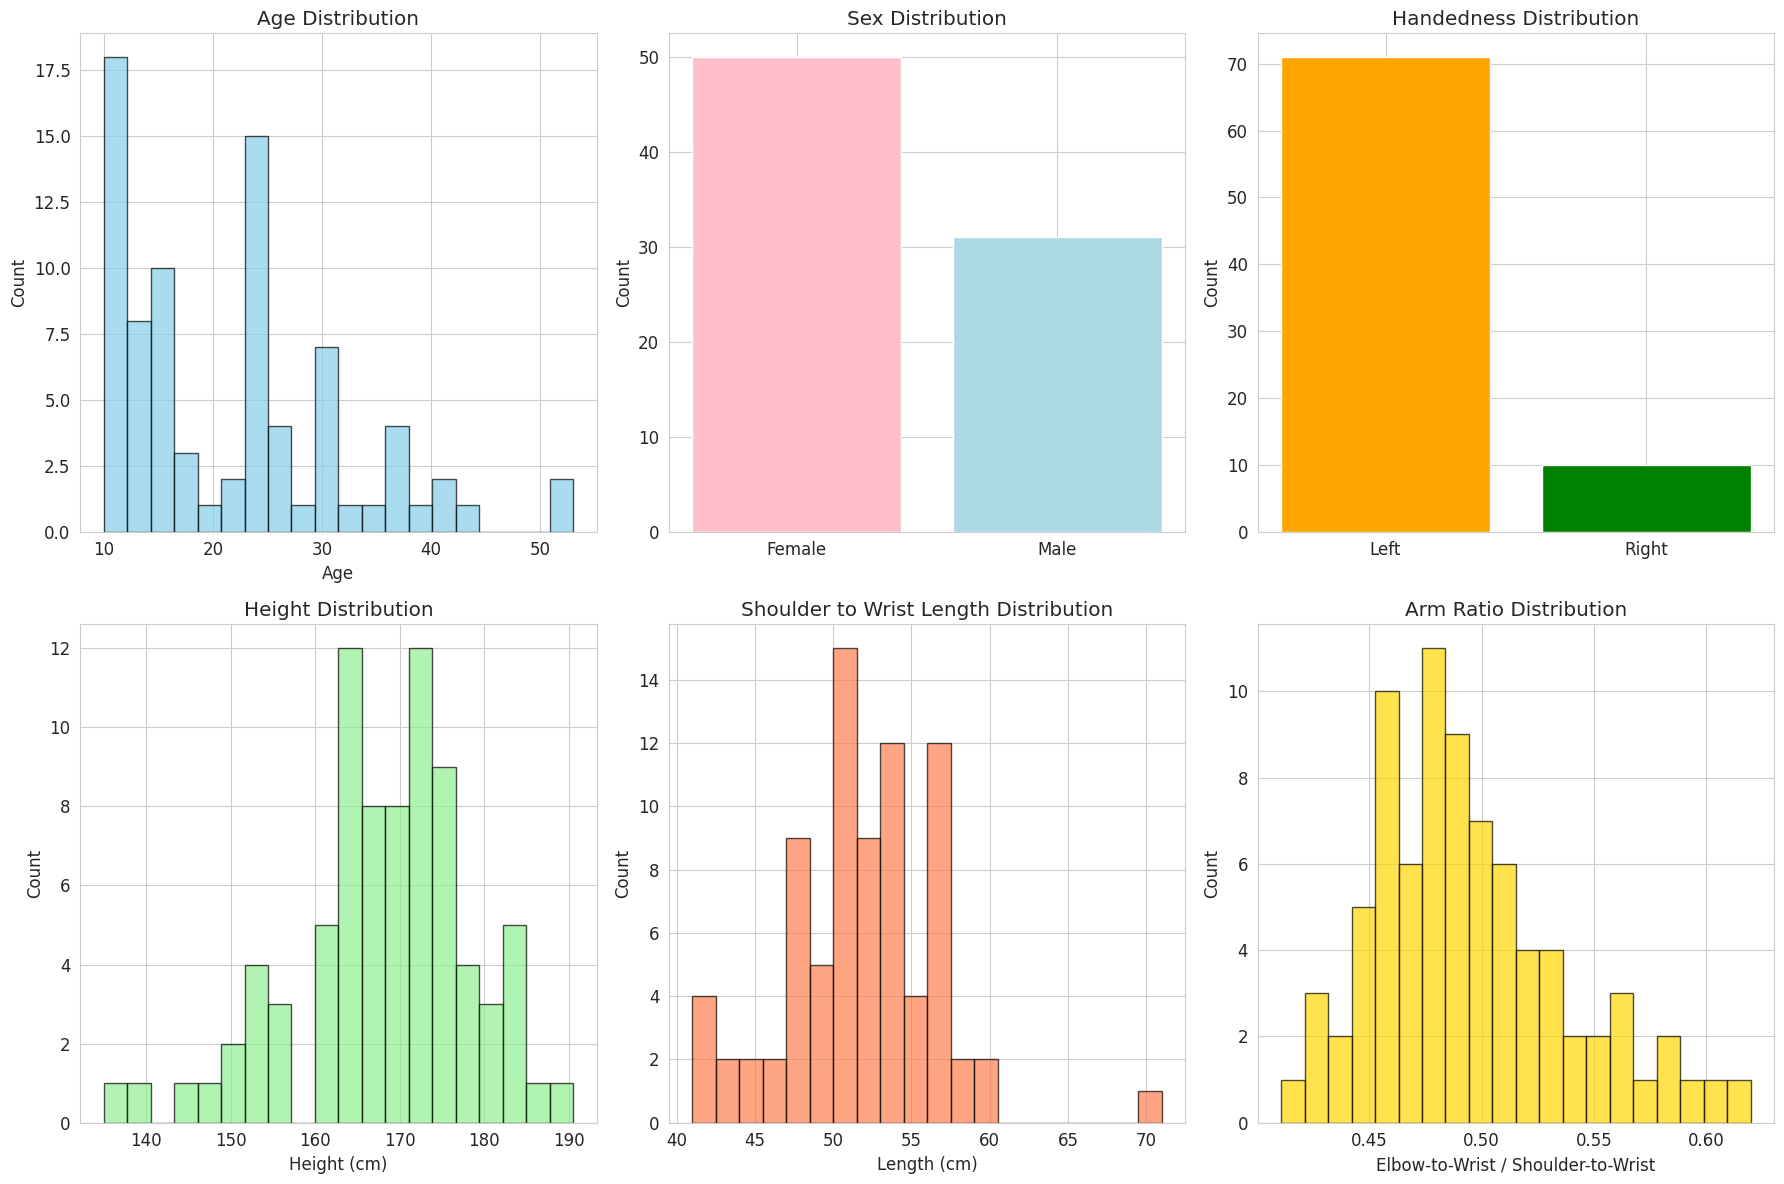

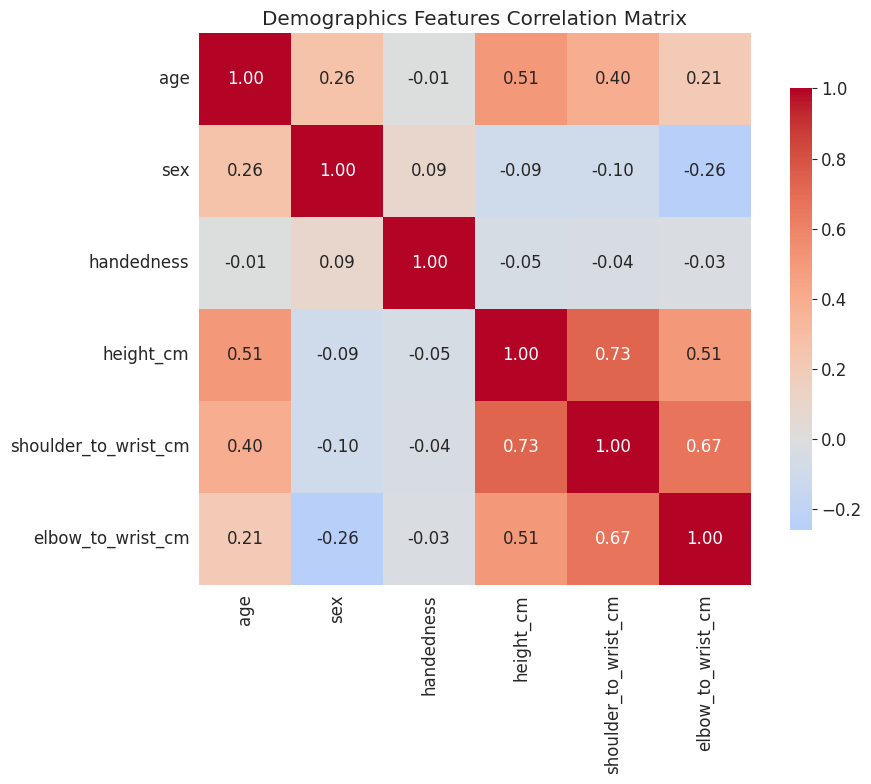

In [ ]:
# Demographics特徴量の分布可視化
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 年齢分布
axes[0, 0].hist(train_demographics['age'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Count')

# 性別分布
sex_counts = train_demographics['sex'].value_counts()
axes[0, 1].bar(['Female', 'Male'], sex_counts.values, color=['pink', 'lightblue'])
axes[0, 1].set_title('Sex Distribution')
axes[0, 1].set_ylabel('Count')

# 利き手分布
hand_counts = train_demographics['handedness'].value_counts()
axes[0, 2].bar(['Left', 'Right'], hand_counts.values, color=['orange', 'green'])
axes[0, 2].set_title('Handedness Distribution')
axes[0, 2].set_ylabel('Count')

# 身長分布
axes[1, 0].hist(train_demographics['height_cm'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Height Distribution')
axes[1, 0].set_xlabel('Height (cm)')
axes[1, 0].set_ylabel('Count')

# 腕の長さ分布
axes[1, 1].hist(train_demographics['shoulder_to_wrist_cm'], bins=20, alpha=0.7, color='coral', edgecolor='black')
axes[1, 1].set_title('Shoulder to Wrist Length Distribution')
axes[1, 1].set_xlabel('Length (cm)')
axes[1, 1].set_ylabel('Count')

# 腕の比率分布
arm_ratio = train_demographics['elbow_to_wrist_cm'] / train_demographics['shoulder_to_wrist_cm']
axes[1, 2].hist(arm_ratio, bins=20, alpha=0.7, color='gold', edgecolor='black')
axes[1, 2].set_title('Arm Ratio Distribution')
axes[1, 2].set_xlabel('Elbow-to-Wrist / Shoulder-to-Wrist')
axes[1, 2].set_ylabel('Count')

plt.tight_layout()
plt.show()

# 相関行列の可視化
numeric_cols = ['age', 'sex', 'handedness', 'height_cm', 'shoulder_to_wrist_cm', 'elbow_to_wrist_cm']
correlation_matrix = train_demographics[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Demographics Features Correlation Matrix')
plt.tight_layout()
plt.show()


## 4. 時系列データとDemographicsの結合


In [ ]:
# 時系列データにdemographics情報を結合
print("時系列データとDemographics情報を結合中...")

# 訓練データの結合
train_with_demographics = train_df.merge(train_demographics_features, on='subject', how='left')
print(f"結合後の訓練データサイズ: {train_with_demographics.shape}")

# テストデータの結合
test_with_demographics = test_df.merge(test_demographics_features, on='subject', how='left')
print(f"結合後のテストデータサイズ: {test_with_demographics.shape}")

# 欠損値チェック
missing_train = train_with_demographics.isnull().sum()
missing_test = test_with_demographics.isnull().sum()

print("\n=== 欠損値チェック ===")
print(f"訓練データの欠損値: {missing_train[missing_train > 0].sum()}")
print(f"テストデータの欠損値: {missing_test[missing_test > 0].sum()}")

# センサー列の特定
sensor_cols = [col for col in train_df.columns if col.startswith(('acc_', 'rot_', 'tof_', 'thm_'))]
demographics_feature_cols = [col for col in train_demographics_features.columns if col != 'subject']

print(f"\nセンサー列数: {len(sensor_cols)}")
print(f"Demographics特徴量数: {len(demographics_feature_cols)}")
print(f"総特徴量数: {len(sensor_cols) + len(demographics_feature_cols)}")

# サンプル表示
print("\n=== 結合データサンプル ===")
display(train_with_demographics[['sequence_id', 'subject', 'gesture'] + demographics_feature_cols[:5]].head())


時系列データとDemographics情報を結合中...
結合後の訓練データサイズ: (574945, 361)
結合後のテストデータサイズ: (107, 356)

=== 欠損値チェック ===
訓練データの欠損値: 3597807
テストデータの欠損値: 0

センサー列数: 332
Demographics特徴量数: 20
総特徴量数: 352

=== 結合データサンプル ===


,sequence_id,subject,gesture,adult_child,age,sex,handedness,height_cm
0,SEQ_000007,SUBJ_059520,Cheek - pinch skin,0,12,1,1,163.0
1,SEQ_000007,SUBJ_059520,Cheek - pinch skin,0,12,1,1,163.0
2,SEQ_000007,SUBJ_059520,Cheek - pinch skin,0,12,1,1,163.0
3,SEQ_000007,SUBJ_059520,Cheek - pinch skin,0,12,1,1,163.0
4,SEQ_000007,SUBJ_059520,Cheek - pinch skin,0,12,1,1,163.0


## 5. スライディングウィンドウ処理（Demographics統合版）


In [ ]:
def create_sliding_windows_with_demographics(df, window_size, stride, sensor_cols, demographics_cols, 
                                           min_sequence_length=10, padding_value=0.0):
    """
    Demographics情報を含むスライディングウィンドウを作成
    
    Parameters:
    -----------
    df : pd.DataFrame
        時系列データ + demographics情報
    window_size : int
        ウィンドウサイズ
    stride : int
        ストライド
    sensor_cols : list
        センサー列のリスト
    demographics_cols : list
        Demographics特徴量列のリスト
    min_sequence_length : int
        最小シーケンス長
    padding_value : float
        パディング値
        
    Returns:
    --------
    tuple
        (X_sensor_windows, X_demographics_windows, y_windows, sequence_info)
    """
    X_sensor_windows = []
    X_demographics_windows = []
    y_windows = []
    sequence_info = []
    
    padded_sequences = 0
    skipped_sequences = 0
    total_windows = 0
    
    # シーケンスごとに処理
    for seq_id in df['sequence_id'].unique():
        seq_data = df[df['sequence_id'] == seq_id].copy()
        seq_data = seq_data.sort_values('sequence_counter')
        
        # 最小シーケンス長チェック
        if len(seq_data) < min_sequence_length:
            skipped_sequences += 1
            continue
        
        # センサーデータとdemographics情報を取得
        sensor_data = seq_data[sensor_cols].values
        demographics_data = seq_data[demographics_cols].iloc[0].values  # 静的データなので最初の行を使用
        gesture = seq_data['gesture'].iloc[0]
        subject = seq_data['subject'].iloc[0]
        
        # 欠損値を0で置換
        sensor_data = np.nan_to_num(sensor_data, nan=padding_value)
        demographics_data = np.nan_to_num(demographics_data, nan=0.0)
        
        # シーケンスがウィンドウサイズより短い場合はパディング
        if len(sensor_data) < window_size:
            padded_sensor = np.full((window_size, len(sensor_cols)), padding_value)
            padded_sensor[:len(sensor_data)] = sensor_data
            sensor_data = padded_sensor
            padded_sequences += 1
            
            # パディングされたシーケンスは1つのウィンドウとして追加
            X_sensor_windows.append(sensor_data)
            X_demographics_windows.append(demographics_data)
            y_windows.append(gesture)
            sequence_info.append({
                'sequence_id': seq_id,
                'subject': subject,
                'window_start': 0,
                'window_end': window_size,
                'is_padded': True,
                'original_length': len(seq_data)
            })
            total_windows += 1
        else:
            # 通常のスライディングウィンドウ処理
            for i in range(0, len(sensor_data) - window_size + 1, stride):
                window_sensor = sensor_data[i:i + window_size]
                
                X_sensor_windows.append(window_sensor)
                X_demographics_windows.append(demographics_data)
                y_windows.append(gesture)
                sequence_info.append({
                    'sequence_id': seq_id,
                    'subject': subject,
                    'window_start': i,
                    'window_end': i + window_size,
                    'is_padded': False,
                    'original_length': len(seq_data)
                })
                total_windows += 1
    
    # numpy配列に変換
    X_sensor_windows = np.array(X_sensor_windows)
    X_demographics_windows = np.array(X_demographics_windows)
    y_windows = np.array(y_windows)
    
    print(f"\n=== ウィンドウ作成統計 ===")
    print(f"総シーケンス数: {len(df['sequence_id'].unique())}")
    print(f"処理されたシーケンス数: {len(df['sequence_id'].unique()) - skipped_sequences}")
    print(f"スキップされたシーケンス数: {skipped_sequences}")
    print(f"パディングされたシーケンス数: {padded_sequences}")
    print(f"総ウィンドウ数: {total_windows}")
    print(f"センサーウィンドウ形状: {X_sensor_windows.shape}")
    print(f"Demographics特徴量形状: {X_demographics_windows.shape}")
    print(f"ラベル形状: {y_windows.shape}")
    
    return X_sensor_windows, X_demographics_windows, y_windows, sequence_info


: 

## 6. 前処理実行とデータ保存

最後に、各ウィンドウ設定で前処理を実行し、結果を保存します。


In [ ]:
# ラベルエンコーダーの準備
label_encoder = LabelEncoder()
all_gestures = train_with_demographics['gesture'].unique()
label_encoder.fit(all_gestures)
print(f"ジェスチャー数: {len(all_gestures)}")
print(f"ジェスチャー: {all_gestures}")

# 各ウィンドウ設定で前処理を実行
preprocessing_results = {}

for config_name, config in WINDOW_CONFIGS.items():
    print(f"\n{'='*60}")
    print(f"前処理実行中: {config_name}")
    print(f"ウィンドウサイズ: {config['window_size']}, ストライド: {config['stride']}")
    print(f"{'='*60}")
    
    # スライディングウィンドウを作成
    X_sensor, X_demographics, y_windows, sequence_info = create_sliding_windows_with_demographics(
        train_with_demographics, 
        config['window_size'], 
        config['stride'], 
        sensor_cols, 
        demographics_feature_cols,
        min_sequence_length=10, 
        padding_value=0.0
    )
    
    # ラベルエンコーディング
    y_encoded = label_encoder.transform(y_windows)
    
    # センサーデータの正規化
    sensor_scaler = StandardScaler()
    n_samples, n_timesteps, n_sensor_features = X_sensor.shape
    X_sensor_flat = X_sensor.reshape(-1, n_sensor_features)
    
    # NaN値の処理
    nan_count = np.isnan(X_sensor_flat).sum()
    if nan_count > 0:
        print(f"  警告: センサーデータにNaN値が{nan_count}個見つかりました。0で置換します。")
        X_sensor_flat = np.nan_to_num(X_sensor_flat, nan=0.0)
    
    X_sensor_normalized = sensor_scaler.fit_transform(X_sensor_flat)
    X_sensor_normalized = X_sensor_normalized.reshape(n_samples, n_timesteps, n_sensor_features)
    
    # Demographics特徴量の正規化
    demographics_scaler = StandardScaler()
    X_demographics_normalized = demographics_scaler.fit_transform(X_demographics)
    
    print(f"\n正規化完了:")
    print(f"  センサーデータ: {X_sensor_normalized.shape}")
    print(f"  Demographics: {X_demographics_normalized.shape}")
    print(f"  ラベル: {y_encoded.shape}")
    
    # 結果を保存
    preprocessing_results[config_name] = {
        'X_sensor': X_sensor_normalized,
        'X_demographics': X_demographics_normalized,
        'y': y_encoded,
        'sequence_info': sequence_info,
        'sensor_scaler': sensor_scaler,
        'demographics_scaler': demographics_scaler,
        'label_encoder': label_encoder,
        'config': config,
        'sensor_cols': sensor_cols,
        'demographics_cols': demographics_feature_cols
    }
    
    print(f"\n{config_name} 前処理完了!")

print(f"\n{'='*60}")
print("全ての前処理が完了しました！")
print(f"処理された設定: {list(preprocessing_results.keys())}")


ジェスチャー数: 18
ジェスチャー: ['Cheek - pinch skin' 'Forehead - pull hairline' 'Write name on leg'
 'Feel around in tray and pull out an object' 'Neck - scratch'
 'Neck - pinch skin' 'Eyelash - pull hair' 'Eyebrow - pull hair'
 'Forehead - scratch' 'Above ear - pull hair' 'Wave hello'
 'Write name in air' 'Text on phone' 'Pull air toward your face'
 'Pinch knee/leg skin' 'Scratch knee/leg skin' 'Drink from bottle/cup'
 'Glasses on/off']

前処理実行中: w64_s16
ウィンドウサイズ: 64, ストライド: 16

=== ウィンドウ作成統計 ===
総シーケンス数: 8151
処理されたシーケンス数: 8151
スキップされたシーケンス数: 0
パディングされたシーケンス数: 4782
総ウィンドウ数: 13393
センサーウィンドウ形状: (13393, 64, 332)
Demographics特徴量形状: (13393, 20)
ラベル形状: (13393,)

正規化完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 20)
  ラベル: (13393,)

w64_s16 前処理完了!

前処理実行中: w128_s32
ウィンドウサイズ: 128, ストライド: 32

=== ウィンドウ作成統計 ===
総シーケンス数: 8151
処理されたシーケンス数: 8151
スキップされたシーケンス数: 0
パディングされたシーケンス数: 7751
総ウィンドウ数: 8673
センサーウィンドウ形状: (8673, 128, 332)
Demographics特徴量形状: (8673, 20)
ラベル形状: (8673,)


In [ ]:
# 前処理データの保存
import json

for config_name, result in preprocessing_results.items():
    print(f"\n=== {config_name} データ保存中 ===")
    
    # 出力ディレクトリの作成
    output_dir = Path(f"../output/experiments/lstm_v2_{config_name}")
    preprocessed_dir = output_dir / "preprocessed"
    preprocessed_dir.mkdir(parents=True, exist_ok=True)
    
    # データの保存
    with open(preprocessed_dir / "X_sensor_windows.pkl", "wb") as f:
        pickle.dump(result['X_sensor'], f)
    
    with open(preprocessed_dir / "X_demographics_windows.pkl", "wb") as f:
        pickle.dump(result['X_demographics'], f)
    
    with open(preprocessed_dir / "y_windows.pkl", "wb") as f:
        pickle.dump(result['y'], f)
    
    with open(preprocessed_dir / "sequence_info.pkl", "wb") as f:
        pickle.dump(result['sequence_info'], f)
    
    with open(preprocessed_dir / "sensor_scaler.pkl", "wb") as f:
        pickle.dump(result['sensor_scaler'], f)
    
    with open(preprocessed_dir / "demographics_scaler.pkl", "wb") as f:
        pickle.dump(result['demographics_scaler'], f)
    
    with open(preprocessed_dir / "label_encoder.pkl", "wb") as f:
        pickle.dump(result['label_encoder'], f)
    
    # 設定とメタデータの保存
    config_data = {
        'window_size': result['config']['window_size'],
        'stride': result['config']['stride'],
        'n_sensor_features': len(result['sensor_cols']),
        'n_demographics_features': len(result['demographics_cols']),
        'n_classes': len(result['label_encoder'].classes_),
        'n_samples': len(result['y']),
        'sensor_cols': result['sensor_cols'],
        'demographics_cols': result['demographics_cols'],
        'gesture_classes': result['label_encoder'].classes_.tolist()
    }
    
    with open(preprocessed_dir / "config.pkl", "wb") as f:
        pickle.dump(config_data, f)
    
    # JSON形式でも保存（可読性のため）
    with open(preprocessed_dir / "config.json", "w") as f:
        json.dump(config_data, f, indent=2)
    
    print(f"保存完了: {preprocessed_dir}")
    print(f"  - X_sensor_windows.pkl: {result['X_sensor'].shape}")
    print(f"  - X_demographics_windows.pkl: {result['X_demographics'].shape}")
    print(f"  - y_windows.pkl: {result['y'].shape}")
    print(f"  - 設定ファイル: config.pkl, config.json")
    print(f"  - 前処理器: sensor_scaler.pkl, demographics_scaler.pkl, label_encoder.pkl")

print(f"\n{'='*60}")
print("LSTM v2 前処理パイプライン完了！")
print("\n次のステップ:")
print("1. LSTM v2モデルの実装（時系列 + demographics入力）")
print("2. Attention機構の追加")
print("3. Transformerベースモデルの実装")
print("4. ハイパーパラメータ最適化")
print(f"\n保存されたデータ:")
for config_name in preprocessing_results.keys():
    print(f"  - ../output/experiments/lstm_v2_{config_name}/preprocessed/")



=== w64_s16 データ保存中 ===
保存完了: ../output/experiments/lstm_v2_w64_s16/preprocessed
  - X_sensor_windows.pkl: (13393, 64, 332)
  - X_demographics_windows.pkl: (13393, 20)
  - y_windows.pkl: (13393,)
  - 設定ファイル: config.pkl, config.json
  - 前処理器: sensor_scaler.pkl, demographics_scaler.pkl, label_encoder.pkl

=== w128_s32 データ保存中 ===
保存完了: ../output/experiments/lstm_v2_w128_s32/preprocessed
  - X_sensor_windows.pkl: (8673, 128, 332)
  - X_demographics_windows.pkl: (8673, 20)
  - y_windows.pkl: (8673,)
  - 設定ファイル: config.pkl, config.json
  - 前処理器: sensor_scaler.pkl, demographics_scaler.pkl, label_encoder.pkl

LSTM v2 前処理パイプライン完了！

次のステップ:
1. LSTM v2モデルの実装（時系列 + demographics入力）
2. Attention機構の追加
3. Transformerベースモデルの実装
4. ハイパーパラメータ最適化

保存されたデータ:
  - ../output/experiments/lstm_v2_w64_s16/preprocessed/
  - ../output/experiments/lstm_v2_w128_s32/preprocessed/


: 

In [ ]:
# 前処理データの保存
import json

for config_name, result in preprocessing_results.items():
    print(f"\n=== {config_name} データ保存中 ===")
    
    # 出力ディレクトリの作成
    output_dir = Path(f"../output/experiments/lstm_v2_{config_name}")
    preprocessed_dir = output_dir / "preprocessed"
    preprocessed_dir.mkdir(parents=True, exist_ok=True)
    
    # データの保存
    with open(preprocessed_dir / "X_sensor_windows.pkl", "wb") as f:
        pickle.dump(result['X_sensor'], f)
    
    with open(preprocessed_dir / "X_demographics_windows.pkl", "wb") as f:
        pickle.dump(result['X_demographics'], f)
    
    with open(preprocessed_dir / "y_windows.pkl", "wb") as f:
        pickle.dump(result['y'], f)
    
    with open(preprocessed_dir / "sequence_info.pkl", "wb") as f:
        pickle.dump(result['sequence_info'], f)
    
    with open(preprocessed_dir / "sensor_scaler.pkl", "wb") as f:
        pickle.dump(result['sensor_scaler'], f)
    
    with open(preprocessed_dir / "demographics_scaler.pkl", "wb") as f:
        pickle.dump(result['demographics_scaler'], f)
    
    with open(preprocessed_dir / "label_encoder.pkl", "wb") as f:
        pickle.dump(result['label_encoder'], f)
    
    # 設定とメタデータの保存
    config_data = {
        'window_size': result['config']['window_size'],
        'stride': result['config']['stride'],
        'n_sensor_features': len(result['sensor_cols']),
        'n_demographics_features': len(result['demographics_cols']),
        'n_classes': len(result['label_encoder'].classes_),
        'n_samples': len(result['y']),
        'sensor_cols': result['sensor_cols'],
        'demographics_cols': result['demographics_cols'],
        'gesture_classes': result['label_encoder'].classes_.tolist()
    }
    
    with open(preprocessed_dir / "config.pkl", "wb") as f:
        pickle.dump(config_data, f)
    
    # JSON形式でも保存（可読性のため）
    with open(preprocessed_dir / "config.json", "w") as f:
        json.dump(config_data, f, indent=2)
    
    print(f"保存完了: {preprocessed_dir}")
    print(f"  - X_sensor_windows.pkl: {result['X_sensor'].shape}")
    print(f"  - X_demographics_windows.pkl: {result['X_demographics'].shape}")
    print(f"  - y_windows.pkl: {result['y'].shape}")
    print(f"  - 設定ファイル: config.pkl, config.json")
    print(f"  - 前処理器: sensor_scaler.pkl, demographics_scaler.pkl, label_encoder.pkl")

print(f"\n{'='*60}")
print("LSTM v2 前処理パイプライン完了！")
print("\n次のステップ:")
print("1. LSTM v2モデルの実装（時系列 + demographics入力）")
print("2. Attention機構の追加")
print("3. Transformerベースモデルの実装")
print("4. ハイパーパラメータ最適化")
print(f"\n保存されたデータ:")
for config_name in preprocessing_results.keys():
    print(f"  - ../output/experiments/lstm_v2_{config_name}/preprocessed/")



=== w64_s16 データ保存中 ===
保存完了: ../output/experiments/lstm_v2_w64_s16/preprocessed
  - X_sensor_windows.pkl: (13393, 64, 332)
  - X_demographics_windows.pkl: (13393, 20)
  - y_windows.pkl: (13393,)
  - 設定ファイル: config.pkl, config.json
  - 前処理器: sensor_scaler.pkl, demographics_scaler.pkl, label_encoder.pkl

=== w128_s32 データ保存中 ===
保存完了: ../output/experiments/lstm_v2_w128_s32/preprocessed
  - X_sensor_windows.pkl: (8673, 128, 332)
  - X_demographics_windows.pkl: (8673, 20)
  - y_windows.pkl: (8673,)
  - 設定ファイル: config.pkl, config.json
  - 前処理器: sensor_scaler.pkl, demographics_scaler.pkl, label_encoder.pkl

LSTM v2 前処理パイプライン完了！

次のステップ:
1. LSTM v2モデルの実装（時系列 + demographics入力）
2. Attention機構の追加
3. Transformerベースモデルの実装
4. ハイパーパラメータ最適化

保存されたデータ:
  - ../output/experiments/lstm_v2_w64_s16/preprocessed/
  - ../output/experiments/lstm_v2_w128_s32/preprocessed/


: 

## サマリーと次のステップ

### 完了した作業
1. ✅ **Demographics特徴量エンジニアリング**: 年齢、性別、身長、利き手などから12+の特徴量を作成
2. ✅ **時系列データとの統合**: センサーデータとdemographics情報を適切に結合
3. ✅ **拡張スライディングウィンドウ**: 時系列ウィンドウ + 静的特徴量のペア作成
4. ✅ **正規化処理**: センサーデータとdemographics特徴量を個別に正規化
5. ✅ **データ保存**: 複数のウィンドウ設定で前処理済みデータを保存

### 作成されたファイル
- `X_sensor_windows.pkl`: 時系列センサーデータ (samples, timesteps, sensor_features)
- `X_demographics_windows.pkl`: 静的demographics特徴量 (samples, demographics_features)
- `y_windows.pkl`: ラベル (samples,)
- `sensor_scaler.pkl`: センサーデータ正規化器
- `demographics_scaler.pkl`: demographics特徴量正規化器
- `label_encoder.pkl`: ジェスチャーラベルエンコーダー
- `config.json`: 設定とメタデータ

### 次のステップ
1. **LSTM v2モデル実装**: 時系列とdemographics特徴量を組み合わせたハイブリッドモデル
2. **Attention機構**: 時系列データの重要な部分に注目する機構の追加
3. **Transformer実装**: 完全にTransformerベースのモデルの実装
4. **モデル評価**: LSTM v1との性能比較
5. **ハイパーパラメータ最適化**: Optunaを使用した最適化

このパイプラインにより、個人の身体的特徴を考慮したより精度の高いジェスチャー認識が期待できます！


In [ ]:
# 前処理データの保存
import json

for config_name, result in preprocessing_results.items():
    print(f"\n=== {config_name} データ保存中 ===")
    
    # 出力ディレクトリの作成
    output_dir = Path(f"../output/experiments/lstm_v2_{config_name}")
    preprocessed_dir = output_dir / "preprocessed"
    preprocessed_dir.mkdir(parents=True, exist_ok=True)
    
    # データの保存
    with open(preprocessed_dir / "X_sensor_windows.pkl", "wb") as f:
        pickle.dump(result['X_sensor'], f)
    
    with open(preprocessed_dir / "X_demographics_windows.pkl", "wb") as f:
        pickle.dump(result['X_demographics'], f)
    
    with open(preprocessed_dir / "y_windows.pkl", "wb") as f:
        pickle.dump(result['y'], f)
    
    with open(preprocessed_dir / "sequence_info.pkl", "wb") as f:
        pickle.dump(result['sequence_info'], f)
    
    with open(preprocessed_dir / "sensor_scaler.pkl", "wb") as f:
        pickle.dump(result['sensor_scaler'], f)
    
    with open(preprocessed_dir / "demographics_scaler.pkl", "wb") as f:
        pickle.dump(result['demographics_scaler'], f)
    
    with open(preprocessed_dir / "label_encoder.pkl", "wb") as f:
        pickle.dump(result['label_encoder'], f)
    
    # 設定とメタデータの保存
    config_data = {
        'window_size': result['config']['window_size'],
        'stride': result['config']['stride'],
        'n_sensor_features': len(result['sensor_cols']),
        'n_demographics_features': len(result['demographics_cols']),
        'n_classes': len(result['label_encoder'].classes_),
        'n_samples': len(result['y']),
        'sensor_cols': result['sensor_cols'],
        'demographics_cols': result['demographics_cols'],
        'gesture_classes': result['label_encoder'].classes_.tolist()
    }
    
    with open(preprocessed_dir / "config.pkl", "wb") as f:
        pickle.dump(config_data, f)
    
    # JSON形式でも保存（可読性のため）
    with open(preprocessed_dir / "config.json", "w") as f:
        json.dump(config_data, f, indent=2)
    
    print(f"保存完了: {preprocessed_dir}")
    print(f"  - X_sensor_windows.pkl: {result['X_sensor'].shape}")
    print(f"  - X_demographics_windows.pkl: {result['X_demographics'].shape}")
    print(f"  - y_windows.pkl: {result['y'].shape}")
    print(f"  - 設定ファイル: config.pkl, config.json")
    print(f"  - 前処理器: sensor_scaler.pkl, demographics_scaler.pkl, label_encoder.pkl")

print(f"\n{'='*60}")
print("LSTM v2 前処理パイプライン完了！")
print("\n次のステップ:")
print("1. LSTM v2モデルの実装（時系列 + demographics入力）")
print("2. Attention機構の追加")
print("3. Transformerベースモデルの実装")
print("4. ハイパーパラメータ最適化")
print(f"\n保存されたデータ:")
for config_name in preprocessing_results.keys():
    print(f"  - ../output/experiments/lstm_v2_{config_name}/preprocessed/")



=== w64_s16 データ保存中 ===
保存完了: ../output/experiments/lstm_v2_w64_s16/preprocessed
  - X_sensor_windows.pkl: (13393, 64, 332)
  - X_demographics_windows.pkl: (13393, 20)
  - y_windows.pkl: (13393,)
  - 設定ファイル: config.pkl, config.json
  - 前処理器: sensor_scaler.pkl, demographics_scaler.pkl, label_encoder.pkl

=== w128_s32 データ保存中 ===
保存完了: ../output/experiments/lstm_v2_w128_s32/preprocessed
  - X_sensor_windows.pkl: (8673, 128, 332)
  - X_demographics_windows.pkl: (8673, 20)
  - y_windows.pkl: (8673,)
  - 設定ファイル: config.pkl, config.json
  - 前処理器: sensor_scaler.pkl, demographics_scaler.pkl, label_encoder.pkl

LSTM v2 前処理パイプライン完了！

次のステップ:
1. LSTM v2モデルの実装（時系列 + demographics入力）
2. Attention機構の追加
3. Transformerベースモデルの実装
4. ハイパーパラメータ最適化

保存されたデータ:
  - ../output/experiments/lstm_v2_w64_s16/preprocessed/
  - ../output/experiments/lstm_v2_w128_s32/preprocessed/


: 